## Install libraries


In [1]:
import warnings
warnings.filterwarnings('ignore')

%pip install beautifulsoup4 requests
from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt
import pandas as pd
import re

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
#download necessary NLTK data
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

## Fetch webpage content


Scrape reviews of Credit Genie on TrustPilot



In [3]:
#fetch webpage content
url = "https://www.trustpilot.com/review/creditgenie.com"
response = requests.get(url)

if response.status_code == 200:
    html_content = response.text
    print("Successfully fetched the webpage content.")
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")
    html_content = None

Successfully fetched the webpage content.


In [4]:
#parse html using beautiful soup
if html_content:
    soup = BeautifulSoup(html_content, 'html.parser')
    print("Successfully parsed the HTML content.")
else:
    print("HTML content is not available for parsing.")


Successfully parsed the HTML content.


## Extract reviews

Analyzed HTML structure, attempt to extract them based on that assumption.


In [5]:
if soup:
    #find all the main review container elements
    review_content_containers = soup.find_all('div', class_='styles_reviewContent__tuXiN')

    reviews_list = []

    for content_container in review_content_containers:
        # navigate up to the parent element that likely contains the rating, author and other details
        review_block = content_container.find_parent()

        #extract review body
        review_body_element = content_container.find('p', class_='typography_body-l__v5JLj')
        review_body = review_body_element.get_text(strip=True) if review_body_element else None

        #extract headline
        headline_element = content_container.find('h2', class_='typography_heading-xs__osRhC')
        headline = headline_element.get_text(strip=True) if headline_element else None

        #extract date of experience
        date_element = content_container.find('p', class_='typography_body-m__k2UI7')
        date_span = date_element.find('span', class_='typography_body-m__k2UI7 typography_appearance-subtle__PYOVM') if date_element else None
        date_of_experience = date_span.get_text(strip=True) if date_span else None

        #ratings as images, in different container
        #extract rating (now search in the parent review_block)
        rating_img = None
        if review_block:
             rating_img = review_block.find('img', alt=lambda x: x and 'Rated' in x and 'out of 5 stars' in x)

        rating_text = rating_img['alt'] if rating_img and 'alt' in rating_img.attrs else None

        rating_value = None
        if rating_text:
            try:
                rating_match = re.search(r'Rated (\d+) out of 5 stars', rating_text)
                if rating_match:
                    rating_value = int(rating_match.group(1))
            except Exception as e:
                print(f"Could not parse rating from text '{rating_text}': {e}")
                pass


        if review_body: #only add reviews that have a body
            reviews_list.append({
                'headline': headline,
                'review_body': review_body,
                'date_of_experience': date_of_experience,
                'rating': rating_value
           })

    reviews = reviews_list

    print(f"Extracted {len(reviews)} complete reviews.")
    # print(reviews[:5])

else:
    print("Soup object is not available for finding review elements.")

Extracted 19 complete reviews.


In [6]:
reviews

[{'headline': 'Taking money out of my account twice in one month , for what purpose!😭',
  'review_body': 'I rate them at 0. If I was satisfied with them, I would expect them to take a payment once a month but these people took  money twice May 7 and May 16, 2025. Then I learned how to unsubscribe by disconnecting my bank account. The only reason I put my account in, I was trying to get approved for the 100 dollars Ithey said I could borrow. So I would like to know what was the purpose for taking the 4.99 twice in one month for!!!',
  'date_of_experience': 'May 06, 2025',
  'rating': 1},
 {'headline': 'Credit Genie withdrawals without permission',
  'review_body': 'Reply from Credit Genie16 minutes agoWe are sorry you had a negative experience.We use an automated system that reviews your bank account transactions and history to determine if you meet our eligibility guidelines.You can disconnect your bank account directly through the "Settings" tab in the Credit Genie app. which will ter

Loop through pages to extract all reviews

In [7]:
base_url = "https://www.trustpilot.com/review/creditgenie.com"
all_reviews = []
num_pages_to_scrape = 11 #number of pages to scrape

#loop through pages for extraction
for page_num in range(1, num_pages_to_scrape + 1):
    page_url = f"{base_url}?page={page_num}"
    print(f"Scraping page: {page_url}")

    try:
        response = requests.get(page_url)
        response.raise_for_status() #raise exception for bad status codes (4xx or 5xx)
        html_content = response.text

        soup = BeautifulSoup(html_content, 'html.parser')

        #---------review extraction (same as before)-----------
        review_content_containers = soup.find_all('div', class_='styles_reviewContent__tuXiN')

        for content_container in review_content_containers:
            review_block = content_container.find_parent()
            # review body
            review_body_element = content_container.find('p', class_='typography_body-l__v5JLj')
            review_body = review_body_element.get_text(strip=True) if review_body_element else None
            # headline
            headline_element = content_container.find('h2', class_='typography_heading-xs__osRhC')
            headline = headline_element.get_text(strip=True) if headline_element else None
            # date
            date_element = content_container.find('p', class_='typography_body-m__k2UI7')
            date_span = date_element.find('span', class_='typography_body-m__k2UI7 typography_appearance-subtle__PYOVM') if date_element else None
            date_of_experience = date_span.get_text(strip=True) if date_span else None
            # search in parent container
            rating_img = None
            if review_block:
                 rating_img = review_block.find('img', alt=lambda x: x and 'Rated' in x and 'out of 5 stars' in x)

            rating_text = rating_img['alt'] if rating_img and 'alt' in rating_img.attrs else None

            rating_value = None
            if rating_text:
                try:
                    rating_match = re.search(r'Rated (\d+) out of 5 stars', rating_text)
                    if rating_match:
                        rating_value = int(rating_match.group(1))
                except Exception as e:
                    print(f"Could not parse rating from text '{rating_text}' on page {page_num}: {e}")


            if review_body:
                all_reviews.append({
                    'headline': headline,
                    'review_body': review_body,
                    'date_of_experience': date_of_experience,
                    'rating': rating_value
                })
        #---------------end of review extraction---------------

        print(f"Extracted {len(review_content_containers)} potential reviews from page {page_num}.")

    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch page {page_num}: {e}")

print(f"\nFinished scraping. Total reviews extracted across all pages: {len(all_reviews)}")

Scraping page: https://www.trustpilot.com/review/creditgenie.com?page=1
Extracted 20 potential reviews from page 1.
Scraping page: https://www.trustpilot.com/review/creditgenie.com?page=2
Extracted 20 potential reviews from page 2.
Scraping page: https://www.trustpilot.com/review/creditgenie.com?page=3
Extracted 20 potential reviews from page 3.
Scraping page: https://www.trustpilot.com/review/creditgenie.com?page=4
Extracted 20 potential reviews from page 4.
Scraping page: https://www.trustpilot.com/review/creditgenie.com?page=5
Extracted 20 potential reviews from page 5.
Scraping page: https://www.trustpilot.com/review/creditgenie.com?page=6
Extracted 20 potential reviews from page 6.
Scraping page: https://www.trustpilot.com/review/creditgenie.com?page=7
Extracted 20 potential reviews from page 7.
Scraping page: https://www.trustpilot.com/review/creditgenie.com?page=8
Extracted 20 potential reviews from page 8.
Scraping page: https://www.trustpilot.com/review/creditgenie.com?page=9


In [8]:
#store reviews in dataframe
if all_reviews:
    df_reviews = pd.DataFrame(all_reviews)
    df_reviews = df_reviews.rename(columns={
        'date_of_experience': 'date',
        'rating': 'rating',
        'author': 'author',
        'headline': 'headline',
        'review_body': 'review'
    })

    print("DataFrame created from extracted reviews.")

    #display all rows
    pd.set_option('display.max_rows', None)
    display(df_reviews)

else:
    print("No reviews were extracted, therfore couldn't create dataframe.")

DataFrame created from extracted reviews.


,headline,review,date,rating
0,Taking money out of my account twice in one mo...,I rate them at 0. If I was satisfied with them...,"May 06, 2025",1
1,Credit Genie withdrawals without permission,Reply from Credit Genie16 minutes agoWe are so...,"December 01, 2024",1
2,This app blows(PLEASE READ. THIS THE TRUTH OF ...,"This app blows.. I have steady income, weekly ...","May 14, 2025",1
3,I do not know who these people are,I do not know who these people are. They keep ...,"May 09, 2025",1
4,"Money taken out of your bank account, but it t...",They are fast about sending you money but when...,"May 07, 2025",2
5,Scammers!,I’ve never used this app but they charged my a...,"April 28, 2025",1
6,I don't know how I got roped into this…,I don't know how I got roped into this one. I'...,"April 19, 2025",1
7,Never heard of this company and they…,Never heard of this company and they got our c...,"April 17, 2025",1
8,Scumbags have NO qualms taking a…,Scumbags have NO qualms taking a BIWEEKLY fee ...,"April 16, 2025",1
9,I’ve tried contacting these people so…,I’ve tried contacting these people so many tim...,"April 11, 2025",1


#Data Cleaning

In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  204 non-null    object
 1   review    204 non-null    object
 2   date      204 non-null    object
 3   rating    204 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.5+ KB


In [10]:
#convert date column into datetime format
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

#EDA

Text(0, 0.5, 'Frequency')

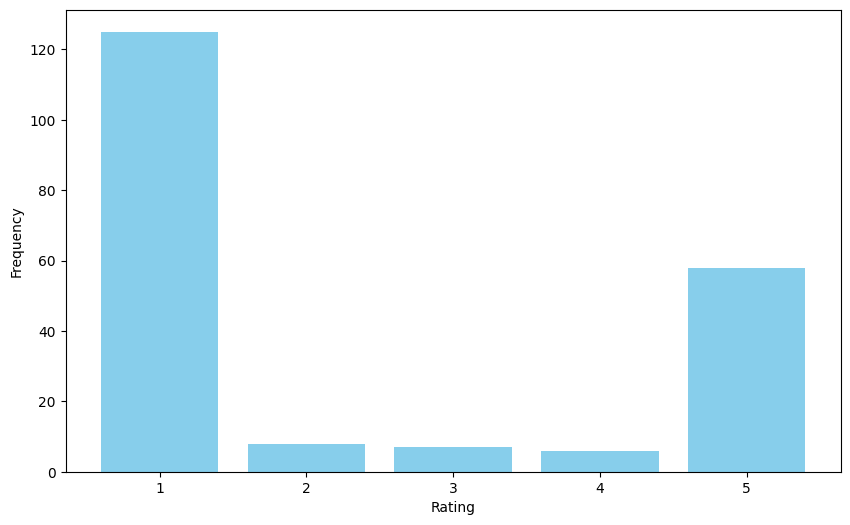

In [11]:
#create histogram of review ratings using matplotlib
plt.figure(figsize=(10,6))
plt.hist(df_reviews['rating'], bins=range(1, 7), align='left', rwidth=0.8, color='skyblue')
plt.xticks(range(1, 6))
plt.xlabel('Rating')
plt.ylabel('Frequency')

quite polarized ratings, mostly negative

In [12]:
# Basic Text Analysis
num_reviews = len(df_reviews)
print(f"Number of reviews: {num_reviews}")

Number of reviews: 204


In [13]:
# Calculate average review length
df_reviews['review_length'] = df_reviews['review'].apply(len)
average_review_length = df_reviews['review_length'].mean()
print(f"Average review length: {average_review_length:.2f} characters")

Average review length: 245.66 characters


# Preprocess the reviews

In [14]:
stop_words = set(stopwords.words('english'))
#add custom stop_words
custom_stop_words = {'im', 'ive','4','99','genie'}
stop_words.update(custom_stop_words)

In [15]:
#download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab/english.pickle')
except LookupError:
    nltk.download('punkt_tab') # Changed from 'punkt' to 'punkt_tab'

def preprocess_text(text):
    if isinstance(text, str):
        #lowercase
        text = text.lower()
        #remove punctuation and non-alphabetic characters
        text = re.sub(r'[^a-z\s]', ' ', text)
        #tokenize
        words = nltk.word_tokenize(text)
        #remove stop words
        words = [word for word in words if word not in stop_words]
        #stemming (commented since might impact sentiment analysis)
       # words = [stemmer.stem(word) for word in words]
       # words = [lemmatizer.lemmatize(word) for word in words]

        return " ".join(words)
    else:
        return "" # Return empty string for non-string inputs

# Apply preprocessing to the 'review' column
df_reviews['processed_review'] = df_reviews['review'].apply(preprocess_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [16]:
df_reviews['processed_review']

,processed_review
0,rate satisfied would expect take payment month...
1,reply credit minutes agowe sorry negative expe...
2,app blows steady income weekly paid good credi...
3,know people keep charging
4,fast sending money take money checking account...
5,never used app charged account reached custome...
6,know got roped one never app never used compan...
7,never heard company got card charged fraud rep...
8,scumbags qualms taking biweekly fee account ma...
9,tried contacting people many times even funny ...


In [17]:
#flatten the list of lists into a single list of words
all_words_list = [word for sublist in df_reviews['processed_review'].str.split() for word in sublist]

In [18]:
#most frequent words after processing
word_counts = Counter(all_words_list)
most_common_words = word_counts.most_common(30) # top 30 words

print("\nMost frequent words (after removing stop words):")
for word, count in most_common_words:
    print(f"- {word}: {count}")


Most frequent words (after removing stop words):
- account: 130
- money: 85
- credit: 78
- get: 76
- app: 67
- bank: 62
- advance: 62
- service: 55
- company: 52
- never: 43
- customer: 37
- back: 36
- people: 34
- time: 34
- need: 30
- loan: 29
- even: 28
- scam: 28
- one: 27
- fee: 27
- take: 25
- pay: 25
- would: 24
- know: 24
- taking: 24
- got: 24
- charge: 24
- give: 19
- cash: 19
- approved: 18


##bigrams

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [49]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=2)
bigram_matrix = bigram_vectorizer.fit_transform(df_reviews['processed_review'])

#sum of counts for each bigram
bigram_counts = bigram_matrix.sum(axis=0)

#get bigram feature names
bigram_feature_names = bigram_vectorizer.get_feature_names_out()

#create dict for bigram names
bigram_counts_list = [(bigram_feature_names[i], bigram_counts[0, i]) for i in range(len(bigram_feature_names))]

#get top 20 bigrams
most_common_bigrams = sorted(bigram_counts_list, key=lambda item: item[1], reverse=True)[:20]

print("\nMost Common Bigrams:")
for bigram, count in most_common_bigrams:
    print(f"- {bigram}: {count}")


Most Common Bigrams:
- customer service: 29
- bank account: 25
- money account: 18
- taking money: 15
- cash advance: 12
- take money: 10
- get advance: 9
- get approved: 9
- money back: 9
- debit card: 8
- money bank: 7
- took money: 7
- connect bank: 6
- need money: 6
- pay back: 6
- account without: 5
- credit great: 5
- get money: 5
- monthly fee: 5
- never heard: 5


Creating network graph using NetworkX and Matplotlib...


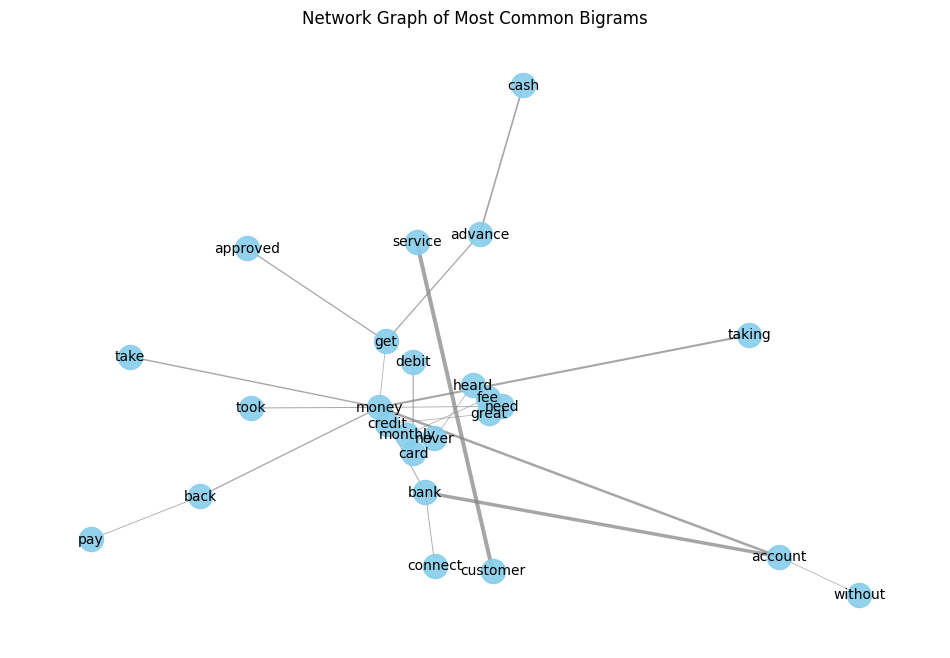

In [20]:
import networkx as nx

G = nx.Graph()

#add nodes and edges base on most common bigrams
for bigram, count in most_common_bigrams:
    word1, word2 = bigram.split()

    G.add_node(word1)
    G.add_node(word2)
    G.add_edge(word1, word2, weight=count)

plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(G) #Kamada-Kawai layout (often good for structure)

#nods
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.9)

#edges, adjust base on weights
edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=[w*0.1 for w in edge_weights], alpha=0.7, edge_color='gray')

#labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Network Graph of Most Common Bigrams")
plt.axis('off')
plt.show()

#Analysis

##Sentiment analysis

In [21]:
#sentiment analysis using VADER
# VADER typically works well with or without stop words.
sia = SentimentIntensityAnalyzer()
df_reviews['sentiment_processed'] = df_reviews['processed_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [22]:
#categorize sentiment based on the processed review sentiment
def get_sentiment_category_processed(score):
    if score >= 0.7:
        return 'Positive'
    elif score <= 0.5:
        return 'Negative'
    else:
        return 'Neutral'

In [23]:
df_reviews['sentiment_category_processed'] = df_reviews['sentiment_processed'].apply(get_sentiment_category_processed)

In [24]:
df_reviews.head()

,headline,review,date,rating,review_length,processed_review,sentiment_processed,sentiment_category_processed
0,Taking money out of my account twice in one mo...,I rate them at 0. If I was satisfied with them...,2025-05-06,1,429,rate satisfied would expect take payment month...,0.7964,Positive
1,Credit Genie withdrawals without permission,Reply from Credit Genie16 minutes agoWe are so...,2024-12-01,1,801,reply credit minutes agowe sorry negative expe...,0.9485,Positive
2,This app blows(PLEASE READ. THIS THE TRUTH OF ...,"This app blows.. I have steady income, weekly ...",2025-05-14,1,653,app blows steady income weekly paid good credi...,0.2598,Negative
3,I do not know who these people are,I do not know who these people are. They keep ...,2025-05-09,1,57,know people keep charging,0.0000,Negative
4,"Money taken out of your bank account, but it t...",They are fast about sending you money but when...,2025-05-07,2,602,fast sending money take money checking account...,0.0258,Negative


In [25]:
def get_combined_sentiment_category(row):
    vader_score = row['sentiment_processed']
    original_rating = row['rating']

    #thresholds VADER
    vader_positive_threshold = 0.8
    vader_negative_threshold = 0.5

    #prioritize original rating for clear cases (1 or 5 stars)
    if original_rating < 3 or vader_score <= vader_negative_threshold:
        return 'Negative'
    elif original_rating >3 or vader_score >= vader_positive_threshold:
        return 'Positive'

    #otherwise, use VADER sentiment with adjusted thresholds
#    if vader_score >= vader_positive_threshold:
#        return 'Positive'
#    elif vader_score <= vader_negative_threshold:
#        return 'Negative'
    else:
        return 'Neutral'

In [26]:
df_reviews['combined_sentiment_category'] = df_reviews.apply(get_combined_sentiment_category, axis=1)

print("Combined Sentiment Distribution:")
display(df_reviews['combined_sentiment_category'].value_counts(normalize=True) * 100)


print("\nSample Reviews with Combined Sentiment:")
display(df_reviews[['headline', 'review', 'rating', 'sentiment_processed', 'combined_sentiment_category']].tail())

Combined Sentiment Distribution:


,proportion
combined_sentiment_category,
Negative,75.490196
Positive,24.019608
Neutral,0.490196



Sample Reviews with Combined Sentiment:


,headline,review,rating,sentiment_processed,combined_sentiment_category
199,Worthless Scam company.Do not trust…,Worthless Scam company.Do not trust them.cance...,1,-0.5106,Negative
200,If I could give negative stars I…,If I could give negative stars I would!! This ...,1,-0.8902,Negative
201,Everytime it is time for my advance to…,Everytime it is time for my advance to come ou...,1,-0.1900,Negative
202,This company is a total scam,This company is a total scam. Rude staff and s...,1,0.5420,Negative
203,Steer clear of this company,Steer clear of this company. The cash advance ...,1,-0.6124,Negative


## Create Document-Term Matrix and Apply Topic Modeling
Convert the preprocessed text into a TF-IDF matrix and apply LDA.

Create a TF-IDF vectorizer and fit it to the preprocessed review text to create the document-term matrix. Then, create an LDA model, specify the number of topics, and fit the model to the TF-IDF matrix to perform topic modeling.

In [27]:
#create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)

#fit and transform the processed reviews to create the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df_reviews['processed_review'])

print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")

Shape of TF-IDF matrix: (204, 568)


In [28]:
#feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print(tfidf_feature_names)

['able' 'absolutely' 'abuse' 'accept' 'access' 'according' 'account'
 'accounts' 'acct' 'action' 'actually' 'address' 'advance' 'advances'
 'advantage' 'advertise' 'afford' 'agreed' 'align' 'allow' 'almost'
 'already' 'also' 'always' 'amazing' 'amount' 'another' 'answer' 'answers'
 'anybody' 'anyone' 'anything' 'app' 'apparently' 'apply' 'approve'
 'approved' 'apps' 'around' 'artist' 'ask' 'asked' 'asking' 'assist'
 'assistance' 'attempt' 'august' 'authorization' 'authorize' 'authorized'
 'available' 'aware' 'away' 'awesome' 'back' 'bad' 'balance' 'bank'
 'banking' 'banks' 'banned' 'bbb' 'believe' 'best' 'better' 'beware' 'big'
 'billed' 'bind' 'bit' 'black' 'blocked' 'borrow' 'bother' 'business'
 'call' 'called' 'came' 'cancel' 'card' 'care' 'cash' 'cause' 'cents'
 'ceo' 'change' 'changed' 'charge' 'charged' 'charges' 'charging' 'chat'
 'check' 'checked' 'checking' 'class' 'clear' 'cleared' 'clearly' 'clears'
 'close' 'closed' 'come' 'comes' 'communicate' 'companies' 'company'
 'compl

## Create Wordcloud

In [29]:
%pip install wordcloud matplotlib

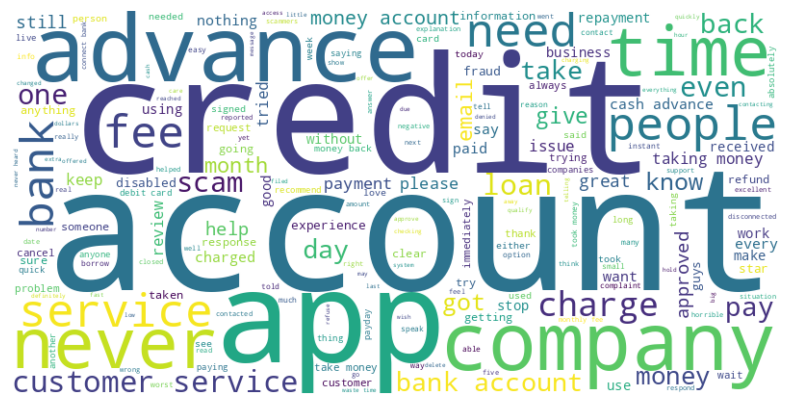

In [30]:
from wordcloud import WordCloud

#join all the preprocessed reviews into a single string
all_processed_reviews_text = " ".join(df_reviews['processed_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_processed_reviews_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Hide axes
plt.show()

In [31]:
print("Top 5 Most Negative Reviews (based on processed review sentiment):")
#filter first, then sort, then select top 5
most_negative_reviews = (
    df_reviews[df_reviews['combined_sentiment_category'] == 'Negative']
    .sort_values(by='sentiment_processed', ascending=True)
    .head(5)
)
display(most_negative_reviews[['headline', 'review', 'sentiment_processed', 'rating']])

print("\nTop 5 Most Positive Reviews (based on processed review sentiment):")
most_positive_reviews = (
    df_reviews[df_reviews['combined_sentiment_category'] == 'Positive']
    .sort_values(by='sentiment_processed', ascending=False)
    .head(5)
)
display(most_positive_reviews[['headline', 'review', 'sentiment_processed', 'rating']])

Top 5 Most Negative Reviews (based on processed review sentiment):


,headline,review,sentiment_processed,rating
121,Was charged over $12 more than my…,Was charged over $12 more than my advance amou...,-0.9497,1
89,I never heard of this company.,I never heard of this company and they charged...,-0.9478,1
184,Fraud,Fraud takes advantage of low income and the El...,-0.9403,1
110,Trying to disable an account,"Tried to apply for a quick loan,which I was de...",-0.9201,1
6,I don't know how I got roped into this…,I don't know how I got roped into this one. I'...,-0.9136,1



Top 5 Most Positive Reviews (based on processed review sentiment):


,headline,review,sentiment_processed,rating
18,Thank you Credit Genie for making my day!,I haven't read but a few reviews. I don't unde...,0.9824,5
48,I wish to appeal this ruling made…credit genie...,I wish to appeal this ruling made today.I am r...,0.9781,5
73,No real big issues here,No real big issues here. I've used when needed...,0.9460,3
68,My experience was an all-around great…,My experience was an all-around great experien...,0.9450,5
87,My experience was easy,"My experience was easy, as long as you pay you...",0.9448,4


## Apply Latent Dirichlet Allocation (LDA)

Apply LDA to the precomputed TF-IDF matrix and display the top words for each topic.

In [32]:
#LDA
n_topics = 3 #try 5 topics first
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=128)

In [33]:
#fit the LDA model to the TF-IDF matrix
lda_output = lda_model.fit_transform(tfidf_matrix)

print(f"LDA model fitted with {n_topics} topics.")
print(f"Shape of LDA output: {lda_output.shape}")

LDA model fitted with 3 topics.
Shape of LDA output: (204, 3)


In [34]:
#dominant topic and topic probability for each review
df_reviews['dominant_topic'] = lda_output.argmax(axis=1)
df_reviews['dominant_topic_probability'] = lda_output.max(axis=1)

In [35]:
#see words in each topic
def display_topics(model, feature_names, num_of_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_of_top_words - 1:-1]]))
    print("-" * 20)

In [36]:
num_of_top_words = 10
print("\nTop words for each topic:")
display_topics(lda_model, tfidf_feature_names, num_of_top_words)


Top words for each topic:
Topic 0:
service get customer company credit advance response account helpful fast
Topic 1:
account app money credit never service bank advance need get
Topic 2:
horrible keep paying advance cancel app charging good stop get
--------------------


### Analyze and Interpret Topics

Examine reviews within each topic and analyze their associated sentiment.

In [37]:
#iterate through each topic
for topic_id in sorted(df_reviews['dominant_topic'].unique()):
    print(f"\n--- Topic {topic_id} ---")

    #filter reviews belonging to this topic
    topic_reviews_df = df_reviews[df_reviews['dominant_topic'] == topic_id]

    #display sentiment distribution for this topic
    sentiment_distribution_topic = topic_reviews_df['sentiment_category_processed'].value_counts(normalize=True) * 100
    print("Sentiment Distribution for Topic:")
    display(sentiment_distribution_topic)

    #display a few sample reviews for this topic
    print("\nSample Reviews for Topic:")
    #show a few positive, neutral, and negative reviews if available
    sample_size = 1 #sample review num to show per category

    positive_samples = topic_reviews_df[topic_reviews_df['sentiment_category_processed'] == 'Positive'].sample(min(sample_size, len(topic_reviews_df[topic_reviews_df['sentiment_category_processed'] == 'Positive'])))
    neutral_samples = topic_reviews_df[topic_reviews_df['sentiment_category_processed'] == 'Neutral'].sample(min(sample_size, len(topic_reviews_df[topic_reviews_df['sentiment_category_processed'] == 'Neutral'])))
    negative_samples = topic_reviews_df[topic_reviews_df['sentiment_category_processed'] == 'Negative'].sample(min(sample_size, len(topic_reviews_df[topic_reviews_df['sentiment_category_processed'] == 'Negative'])))


    if not positive_samples.empty:
        print("\nPositive Samples:")
        for index, row in positive_samples.iterrows():
            print(f"- Headline: {row['headline']}")
            print(f"  Review: {row['review'][:200]}...") #display first 200 characters
            print(f"  Sentiment: {row['sentiment_category_processed']}")
            print("-" * 10)

    if not neutral_samples.empty:
        print("\nNeutral Samples:")
        for index, row in neutral_samples.iterrows():
            print(f"- Headline: {row['headline']}")
            print(f"  Review: {row['review'][:200]}...")
            print(f"  Sentiment: {row['sentiment_category_processed']}")
            print("-" * 10)

    if not negative_samples.empty:
        print("\nNegative Samples:")
        for index, row in negative_samples.iterrows():
            print(f"- Headline: {row['headline']}")
            print(f"  Review: {row['review'][:200]}...")
            print(f"  Sentiment: {row['sentiment_category_processed']}")
            print("-" * 10)

    print("=" * 50)


--- Topic 0 ---
Sentiment Distribution for Topic:


,proportion
sentiment_category_processed,
Negative,61.904762
Positive,22.222222
Neutral,15.873016



Sample Reviews for Topic:

Positive Samples:
- Headline: Credit genie is a great if you get approved
  Review: Credit genie is a great app for getting money in a pinch, but after switching my bank (due to my old bank closing) I never get approved for anything. Great if you get approved, but not so good if you ...
  Sentiment: Positive
----------

Neutral Samples:
- Headline: Why the six hour wait for deposit of…
  Review: Why the six hour wait for deposit of loanFirst time I was approved for $10 it went in immediately...But after being approved for $100 today , I have to wait until 9 pm......
  Sentiment: Neutral
----------

Negative Samples:
- Headline: This app could be better…
  Review: It’s not bad but I wish there was option to pay before due date or asking to pay now. Also, hard to get in touch with customer support, I never  had my question answered....
  Sentiment: Negative
----------

--- Topic 1 ---
Sentiment Distribution for Topic:


,proportion
sentiment_category_processed,
Negative,57.142857
Positive,29.464286
Neutral,13.392857



Sample Reviews for Topic:

Positive Samples:
- Headline: Taking money out of my account twice in one month , for what purpose!😭
  Review: I rate them at 0. If I was satisfied with them, I would expect them to take a payment once a month but these people took  money twice May 7 and May 16, 2025. Then I learned how to unsubscribe by disco...
  Sentiment: Positive
----------

Neutral Samples:
- Headline: Not pushy!
  Review: They have been fair and worked well with me when I could only make partial payments on a recent advance. I feel comfortable using this app and don't worry about anything....
  Sentiment: Neutral
----------

Negative Samples:
- Headline: This is clearly an account skimming…
  Review: This is clearly an account skimming scam. They’re waiting for someone to get in a bind, then charge them money for a cash advance they either won’t give you, or according to a lot of App Store reviews...
  Sentiment: Negative
----------

--- Topic 2 ---
Sentiment Distribution for Topic:


,proportion
sentiment_category_processed,
Negative,86.206897
Positive,10.344828
Neutral,3.448276



Sample Reviews for Topic:

Positive Samples:
- Headline: I wasn't offered any kind of loan but…
  Review: I wasn't offered any kind of loan but they charging my bank account every two weeks and I get nothing this is a scam to the fullest they have no phone number you can call scammers...
  Sentiment: Positive
----------

Neutral Samples:
- Headline: This company is a total scam
  Review: This company is a total scam. Rude staff and support, and they will take your money and subscription fee despite you cancelling it, and block you! Unreal. App wouldn’t ever load or crashed half the ti...
  Sentiment: Neutral
----------

Negative Samples:
- Headline: It’s horrible and frustrating
  Review: It’s horrible and frustrating. The app doesn’t work when it’s time to sign in to pay your bill. It’s always some kind of issues with the app every month and you can never get in contact with the help ...
  Sentiment: Negative
----------


Topic 0
* Top Words:
service, get, customer, company, credit, advance, response, account, helpful, fast

* Sentiment Distribution:

  * Negative: 61.9%

  * Positive: 22.2%

  * Neutral: 15.9%

* Sample Reviews:

  * Positive: “I love credit-Genie, it works for me...”

  * Neutral: “Responded quickly to a request. They are fantastic to work with...”

  * Negative: “Their terms are fair. But, if I get one cash advance immediately after paying off the previous one, I get approved for a lower amount...”

* Interpretation:
This topic centers on customer service and experiences with getting advances, with a mix of both positive and negative experiences, but skewed negative.
Potential Topic Name:
Customer Service & Advance Experience

Topic 1
* Top Words:
account, app, money, credit, never, service, bank, advance, need, get

* Sentiment Distribution:

  * Negative: 57.1%

  * Positive: 29.5%

  * Neutral: 13.4%

* Sample Reviews:

  * Positive: “The experience I have with Credit Genie is great...”

  * Neutral: “Put my money back in to my account you never rendered, you never did any services for me...”

  * Negative: “Poor excuse of a payday loan... now they’re taking money out of my account way too soon...”

* Interpretation:
This topic is focused on account and app issues, especially related to money management and timing of transactions. Many reviews mention problems with money being taken out or not returned, but some users still report positive experiences.
Potential Topic Name:
Account & App Transaction Issues

Topic 2
* Top Words:
horrible, keep, paying, advance, cancel, app, charging, good, stop, get

* Sentiment Distribution:

  * Negative: 86.2%

  * Positive: 10.3%

  * Neutral: 3.4%

* Sample Reviews:

  * Positive: “Why is Credit Genie taking out a fee but I’m not eligible for an advance? Please help this make sense...” (Note: This is labeled positive, but the text is actually negative/neutral in tone, indicating possible mislabeling.)

  * Neutral: “This company is a total scam. Rude staff and support, and they will take your money and subscription fee despite you cancelling it...”

  * Negative: “Horrible service even worse trying to cancel it. They don't make things easy...”

* Interpretation:
This topic is overwhelmingly negative, focusing on recurring charges, difficulties with cancellation, and accusations of scammy behavior.
Potential Topic Name:
Recurring Charges, Cancellation & Scam Concerns

##Visualization

In [38]:
!pip install pyldavis

In [39]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models

In [40]:
# Create a dictionary from the processed reviews
processed_reviews_list = [review.split() for review in df_reviews['processed_review']]
dictionary = Dictionary(processed_reviews_list)

# Create a corpus (Bag of Words representation)
corpus = [dictionary.doc2bow(text) for text in processed_reviews_list]

# You can adjust parameters like num_topics, passes, etc.
gensim_lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=10, workers=2)


vis = pyLDAvis.gensim_models.prepare(gensim_lda_model, corpus, dictionary)

#display in notebook
pyLDAvis.display(vis)

In [44]:
# Save the pyLDAvis visualization as an HTML file
html_file_path = 'lda_visualization.html'
pyLDAvis.save_html(vis, html_file_path)

print(f"pyLDAvis visualization saved to {html_file_path}")

pyLDAvis visualization saved to lda_visualization.html


#Insights

Based on the analysis we performed:

* Review Ratings: <br>Review ratings showed a polarized distribution, with a significant number of 1-star reviews and a smaller peak at 5-star reviews. This shows that Credit Genie receives mixed but predominantly negative sentiment.

* Common Words and Phrases: <br>After preprocessing, the most frequent words and bigrams highlighted key themes in the reviews, such as "account," "money," "credit," "app," "bank account," "customer service," and "taking money". When inspecting original reviews for deep dive, it confirms that the main review topics are about financial transactions, the app itself, and user interactions with customer support.

* Sentiment Analysis:<br> The sentiment analysis using VADER showed a high percentage of reviews classified as Negative (around 75%), aligning with the high distribution of negative ratings.

* Topic Modeling (LDA): <br>The LDA model identified three main topics:
1. Topic 0, Customer Service & Advance Experience: This topic focuses on interactions with support and the process of getting cash advances. While some positive reviews exist, the sentiment in this topic is skewed negative.
2. Topic 1, Account & Transaction Issues: This topic is centered around bank accounts, the app, and money transactions, with many complaints about unauthorized or unclear charges and issues with accessing funds. This topic also had a mixed but largely negative sentiment.
3. Topic 2, Recurring Charges, Cancellation & Scam Concerns: This topic is overwhelmingly negative and contained reviews explicitly mentioning recurring fees, difficulties canceling services, and emotional accusations of the company being a scam.

In summary, the reviews for Credit Genie on TrustPilot indicate significant user dissatisfaction, primarily stemming from issues related to unauthorized charges, difficulties with the app and accessing funds, problems with customer service, and concerns about recurring fees and the legitimacy of the service. While some users have positive experiences, the majority express negative sentiment, particularly focusing on financial transparency and service reliability.

Main Problem Identified: <br><br>Credit Genie seems to be using 3rd Party Services that charges a $4.99 monthly fee just for connecting users' banks. However, since the fee "does not guarantee your eligibility for the advance and is simply there to keep your bank connected", this causes major dissatisfaction as many users are ineligible for the services or are inactive but are still charged, which cause them to feel "scammed" by the company. Many users also mistakenly think uninstalling the app would automatically terminate the service which isn't the case.

**Recommendation:
Clarify and improve bank connection fee policy and user communication**

A significant proportion of Credit Genie users express dissatisfaction with the recurring $4.99 “Bank Connection Fee,” which is charged simply for maintaining a linked bank account—even if the user is ineligible for a cash advance or is not actively using the service.<br><br>
Many reviewers report feeling “scammed” by ongoing charges, particularly when they are denied advances or believe that uninstalling the app would automatically terminate the service and associated fees. In reality, as outlined in Credit Genie’s own terms, users must actively disconnect their bank account within the app to stop the fee, and uninstalling the app alone does not cancel the subscription.

This leads to the following business risks:

* High volume of negative sentiment (over 75% negative reviews) and repeated complaints about unauthorized or confusing charges.

* Risk of regulatory scrutiny and reputational damage due to perceived lack of transparency and customer frustration.

* Increased customer support burden from users seeking refunds or disputing charges.

Actionable Steps for Product Upgrade:

1. Enhance Fee Transparency:
Clearly communicate that the Bank Connection Fee is charged regardless of advance eligibility and that it must be canceled by disconnecting the bank account, not by uninstalling the app.

2. Simplify Cancellation:
Streamline the process for disconnecting a bank account and stopping the fee. Provide in-app prompts and email confirmations to guide users through cancellation and make this option highly visible.

3. Proactive Notifications:
Notify users before each fee is charged, especially if they have not recently used the service or are ineligible for advances. Remind them how to cancel if they no longer wish to be charged.

4. Customer Education:
Launch a customer education campaign (FAQs, tutorial videos, in-app messages) clarifying how the service works, how to cancel, and what the fee covers.

By implementing the above recommendations, we expect to:

* Reduce customer complaints and charge disputes.

* Improve user trust and brand reputation.

* Lower customer support costs.

* Increased likelihood of positive reviews and referrals.

#File downloads

In [41]:
#download df to csv
df_reviews.to_csv('df_reviews.csv', index=False)

In [46]:
# Create a dataframe to store top words per topic (Duplicated from a previous cell for standalone execution)
topic_words = {}
num_of_top_words = 20 # Number of top words to display for each topic

for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[:-num_of_top_words - 1:-1]
    top_words = [tfidf_feature_names[i] for i in top_words_indices]
    topic_words[f'Topic {topic_idx}'] = top_words

df_topic_words = pd.DataFrame(topic_words)


# Rename columns based on topic interpretation
df_topic_words = df_topic_words.rename(columns={
    'Topic 0': 'Customer Service',
    'Topic 1': 'Account & Transaction',
    'Topic 2': 'Charges & Cancellation'
})

print("DataFrame with renamed columns:")
display(df_topic_words)

DataFrame with renamed columns:


,Customer Service,Account & Transaction,Charges & Cancellation
0,service,account,horrible
1,get,app,keep
2,customer,money,paying
3,company,credit,advance
4,credit,never,cancel
5,advance,service,app
6,response,bank,charging
7,account,advance,good
8,helpful,need,stop
9,fast,get,get


In [ ]:
#transform df to long format
df_topic_words_melted = df_topic_words.melt(var_name='topic', value_name='word')

print("Transformed DataFrame:")
display(df_topic_words_melted)

In [ ]:
df_topic_words.to_csv('df_topic_words_melted.csv', index=False)